In [2]:
import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
%matplotlib inline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold

### Load in the the data

In [3]:
df = pd.read_csv('/Users/ginodefalco/dsi/dsi_repo/DSI_SM_3/curriculum/week-01/4.1-More-Visualization-EDA/assets/datasets/indeed-scraped-job-postings.csv')
df.head()


,city,company,salary,summary,title,parsed_salary
0,San+Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San+Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San+Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0
3,San+Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0
4,San+Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0


In [4]:
df.shape

(4791, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 6 columns):
city             4791 non-null object
company          4791 non-null object
salary           4791 non-null object
summary          4791 non-null object
title            4791 non-null object
parsed_salary    4789 non-null float64
dtypes: float64(1), object(5)
memory usage: 224.6+ KB


## Domain & Data set:

This data set contains a recent web-scraped list of Data Science jobs from a variety of job markets from Indeed.com, a job-listings website. It contains 4,791 rows and 6 columns of data including:

- City (City in which the job listings were collected)
- Company (Companies that listed the job liosting)
- Salary (Uncleaned salary range for each job listing)
- Summary (A brief description of each job listing)
- Title (A general title given to each job listing)
- Parsed Salary (Official salary, which looks to have been determined by the web-scraper, for each job listing) 



## Problem Statement:

In this project, we are going to collect salary information on data science jobs in a variety of markets. Then using the location, title, and summary of the job, we will attempt to predict a corresponding salary for that job. While most listings do not come with salary information, being able to predict the expected salaries for other listings will be extremely useful for negotiations.

Normally we could use regression for this task, however, instead we will convert this into a classification problem and use Logistic Regression. While more precision may be better, there is a fair amount of natural variance in job salaries, therefore, predicting a range may be useful. We will be focused on using the listings with salary information to build a model and predict salaries.

## Solution:

We need to inspect this data from Indeed.com on data science salary trends for analysis and find out what factors most directly impact salaries (Title, location, etc.). In this case, we do not want to predict mean salary as would be done in a regression. We believe that salary is better represented in categories. We need to test, validate, and describe our models. What factors predict salary category? How do our models perform? Author a report detailing the analysis.

Judging from the size of our data set, we may encounter a problem with not having enough data. We will adjust one of our logistic regression models, and explain what it is doing and any tradeoffs. Plot the ROC curve.

Text variables and regularization:
Part 1: Job descriptions contain more potentially useful information you could leverage. We will use the job summary and Title to find words we think would be important and add them as predictors to a model.
Part 2: Gridsearch parameters for Ridge and Lasso for this model and report the best model.

Goal: 
- Clean data 
- Run logistic regression 
- Derive insights
- Present findings

In [143]:
# Clean up city column
df['city'] = df['city'].str.replace('+', ' ')
df['city'].head()

0    San Francisco
1    San Francisco
2    San Francisco
3    San Francisco
4    San Francisco
Name: city, dtype: object

In [144]:
# Drop or replace bad values
df = df.dropna()
df.head()

,city,company,salary,summary,title,parsed_salary
0,San Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0
3,San Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0
4,San Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0


In [145]:
# NAN's are indeed dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 4790
Data columns (total 6 columns):
city             4789 non-null object
company          4789 non-null object
salary           4789 non-null object
summary          4789 non-null object
title            4789 non-null object
parsed_salary    4789 non-null float64
dtypes: float64(1), object(5)
memory usage: 261.9+ KB


In [146]:
from IPython.display import Image
Image("Salary by City.png")

In [147]:
from IPython.display import Image
Image("Title by Salary.png")

In [148]:
df.describe()

,parsed_salary
count,4789.000000
mean,66183.785550
std,64348.141986
min,2333.000000
25%,5950.000000
50%,74550.000000
75%,130000.000000
max,300000.000000


In [149]:
# Find median salary
ps = df['parsed_salary'].median()
ps

74550.0

In [150]:
# Change monthly salaries into yearly
df['parsed_salary'] = df['parsed_salary'].apply(lambda x: x*12 if x < 10000 else x)
df.head()

,city,company,salary,summary,title,parsed_salary
0,San Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0
3,San Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0
4,San Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0


In [151]:
# bLooks like they have all been changed
df['parsed_salary'].min()

27996.0

In [152]:
# Now, to separate salary into high and low. 75,000 is pretty close to the median, so we'll use that value.
df['salary'] = df['parsed_salary'].apply(lambda x: 0 if x <= 75000 else 1)
df.head(50)

,city,company,salary,summary,title,parsed_salary
0,San Francisco,MarkMonitor,1,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San Francisco,Workbridge Associates,1,3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San Francisco,Mines.io,1,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0
3,San Francisco,Workbridge Associates,1,In this position you will share programming an...,Data Scientist,165000.0
4,San Francisco,Smith Hanley Associates,1,"This person will recruit, build and lead a tea...",Data Scientist,140000.0
5,San Francisco,HSF Consulting,1,Teams included Data Services(including data en...,VP of Data Services,300000.0
6,San Francisco,All-In Analytics,1,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,125000.0
7,San Francisco,Brilent,1,"Perform large-scale data analysis, find intere...",Senior Data Scientist,130000.0
8,San Francisco,HSF Consulting,1,More data- they simply have more data than the...,Senior Data Scientist,160000.0
9,San Francisco,All-In Analytics,1,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,125000.0


In [153]:
df['salary'].value_counts()


1    3095
0    1694
Name: salary, dtype: int64

In [154]:
# Cities with highest avg salary
city_sal = df.groupby(['city']).agg({'parsed_salary': np.mean})
city_sal = city_sal.sort_values(ascending=False, by = 'parsed_salary')
city_sal.head(10)


,parsed_salary
city,
New York,139601.542141
San Francisco,137866.834568
Chicago,127431.473191
Austin,71941.290563
Seattle,71005.792135


In [155]:
# Companies with highest avg salary...Not that helpful
company_sal = df.groupby(['company']).agg({'parsed_salary': np.mean})
company_sal = company_sal.sort_values(ascending=False, by = 'parsed_salary')
company_sal.head(10)


,parsed_salary
company,
HSF Consulting,253333.333333
Oliver James Associates,215000.000000
Technical Source,200000.000000
Hire Solutions Inc.,200000.000000
Datacom Technology Group,200000.000000
Averity,185500.000000
Penfield Search Partners,185000.000000
MarkMonitor,180000.000000
LT,168333.333333


In [156]:
# Titles with highest avg salary
title_sal = df.groupby(['title']).agg({'parsed_salary': np.mean})
title_sal = title_sal.sort_values(ascending=False, by = 'parsed_salary')
title_sal.head(10)


,parsed_salary
title,
VP of Data Services,300000.0
Quantitative Analyst (Big Data Focus) at $10+ Billion Hedge...,250000.0
Vice President Engineering (Big Data/ Machine Learning),227500.0
Quantitative Data Scientist - Large Asset Manager,225000.0
VP - Predictive Modeling Actuary,215000.0
Machine Learning Research Scientist - Hedgefund,200000.0
Quantitative Analyst (Fundamental Quant Equities) - Hedge Fu...,200000.0
"Quantitative Researcher, Machine Learning & Bayesian inferen...",200000.0
Junior Quantitative Analyst / Developer for $5B Hedge Fund,200000.0


In [157]:
# Let's group some important key words from the 'Title' column into feature columns
df['title'].unique()

array(['Data Scientist', 'Senior Data Scientist',
       'Full-Stack Data Scientist', 'VP of Data Services',
       'Fraud Data Scientist', 'Python Developer (Machine Learning)',
       'Staff Research Associate, PMB',
       'Chief Algorithm Developer (Signal Processing) - Wearables',
       'Post-Doctoral Scholar-Employee: Analysis of omics data',
       'Principal Data Scientist', 'Data Scientist (Econometrics)',
       'Data Scientist (Statistics/Economics)',
       'Data Scientist (Machine Learning)',
       'Senior NLP Scientist/Engineer',
       'Senior Data Scientist (Autonomous Vehicle Research)',
       'VP - Predictive Modeling / Data Scientist',
       'Database Administrator, GSE', 'Scientific Researcher',
       'Vice President Engineering (Big Data/ Machine Learning)',
       'Quality Control Scientist',
       'Administrative Analyst/Specialist, Exempt I - Office of Rese...',
       'Senior Data Scientist (Python, R, recommendation)',
       'Data Scientist (Natural Lan

In [158]:
def title_categorizer(x):
    x = x.lower()
    if 'junior' in x or 'jr' in x or 'assistant' in x:
        return 'Junior Data Scientist'
    elif 'senior' in x or 'sr' in x or 'vp' in x:
        return 'Senior Data Scientist'
    elif 'analyst' in x:
        return 'Data Analyst'
    elif 'manager' in x:
        return 'Manager'
    else:
        return 'Other Jobs'
    
df['Title'] = df['title'].map(title_categorizer)
df.head(5)

,city,company,salary,summary,title,parsed_salary,Title
0,San Francisco,MarkMonitor,1,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0,Other Jobs
1,San Francisco,Workbridge Associates,1,3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0,Senior Data Scientist
2,San Francisco,Mines.io,1,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0,Other Jobs
3,San Francisco,Workbridge Associates,1,In this position you will share programming an...,Data Scientist,165000.0,Other Jobs
4,San Francisco,Smith Hanley Associates,1,"This person will recruit, build and lead a tea...",Data Scientist,140000.0,Other Jobs


In [159]:
# # Let's group some important key words from the 'Summary' column into feature columns

In [160]:
def summary_categorizer(x):
    x = x.lower()
    if 'python' in x:
        return 'python'
    elif 'big data' in x:
        return 'big data'
    elif 'machine learning' in x:
        return 'machine learning'
    elif 'stat' in x:
        return 'statitician'
    elif 'sql' in x:
        return 'SQL'
    elif 'develop' in x:
        return 'developer'
    elif 'data engineer' in x:
        return 'Data Engineer'
    elif 'natural language processing' in x:
        return 'NLP'
    elif 'geospatial' in x:
        return 'Geospatial'
    else:
        return 'Other'
    
df['Summary'] = df['summary'].map(summary_categorizer)
df.head()

,city,company,salary,summary,title,parsed_salary,Title,Summary
0,San Francisco,MarkMonitor,1,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0,Other Jobs,machine learning
1,San Francisco,Workbridge Associates,1,3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0,Senior Data Scientist,python
2,San Francisco,Mines.io,1,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0,Other Jobs,developer
3,San Francisco,Workbridge Associates,1,In this position you will share programming an...,Data Scientist,165000.0,Other Jobs,Other
4,San Francisco,Smith Hanley Associates,1,"This person will recruit, build and lead a tea...",Data Scientist,140000.0,Other Jobs,Other


In [161]:
feature_df = pd.DataFrame(df, columns = ['salary', 'Title', 'Summary'])
feature_df.head()

,salary,Title,Summary
0,1,Other Jobs,machine learning
1,1,Senior Data Scientist,python
2,1,Other Jobs,developer
3,1,Other Jobs,Other
4,1,Other Jobs,Other


In [162]:
feature_df2 = pd.get_dummies(feature_df)
feature_df2.head()

,salary,Title_Data Analyst,Title_Junior Data Scientist,Title_Manager,Title_Other Jobs,Title_Senior Data Scientist,Summary_Data Engineer,Summary_NLP,Summary_Other,Summary_SQL,Summary_big data,Summary_developer,Summary_machine learning,Summary_python,Summary_statitician
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
feature_df2.columns.values

array(['salary', 'Title_Data Analyst', 'Title_Junior Data Scientist',
       'Title_Manager', 'Title_Other Jobs', 'Title_Senior Data Scientist',
       'Summary_Data Engineer', 'Summary_NLP', 'Summary_Other',
       'Summary_SQL', 'Summary_big data', 'Summary_developer',
       'Summary_machine learning', 'Summary_python', 'Summary_statitician'], dtype=object)

In [164]:
#dat=dat.drop(['a'], axis=1, inplace=true)
#X = feature_df.drop(['salary'], axis=1)

X = feature_df2.drop(['Title_Other Jobs', 'Summary_Other'], axis=1)
X.head()

,salary,Title_Data Analyst,Title_Junior Data Scientist,Title_Manager,Title_Senior Data Scientist,Summary_Data Engineer,Summary_NLP,Summary_SQL,Summary_big data,Summary_developer,Summary_machine learning,Summary_python,Summary_statitician
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
X['Summary_SQL'].sum()

4.0

In [166]:
X.shape

(4789, 13)

In [167]:
X_corr = X.corr()
X_corr

,salary,Title_Data Analyst,Title_Junior Data Scientist,Title_Manager,Title_Senior Data Scientist,Summary_Data Engineer,Summary_NLP,Summary_SQL,Summary_big data,Summary_developer,Summary_machine learning,Summary_python,Summary_statitician
salary,1.000000,-0.040280,-0.024069,0.221204,0.415154,0.010692,0.010692,0.021390,0.206777,0.389813,0.010873,0.222429,-0.011777
Title_Data Analyst,-0.040280,1.000000,-0.004657,-0.027785,-0.052657,-0.001343,-0.001343,0.232681,-0.025972,-0.033874,-0.004657,-0.027938,0.091895
Title_Junior Data Scientist,-0.024069,-0.004657,1.000000,-0.014986,-0.028401,-0.000724,-0.000724,-0.001449,0.002103,-0.017052,-0.002512,-0.015069,0.177759
Title_Manager,0.221204,-0.027785,-0.014986,1.000000,-0.169430,-0.004321,-0.004321,-0.008645,-0.083569,-0.159523,-0.014986,-0.089894,-0.020771
Title_Senior Data Scientist,0.415154,-0.052657,-0.028401,-0.169430,1.000000,-0.008189,-0.008189,-0.016384,-0.150868,0.127550,-0.008926,-0.166836,-0.004157
Summary_Data Engineer,0.010692,-0.001343,-0.000724,-0.004321,-0.008189,1.000000,-0.000209,-0.000418,-0.004039,-0.007798,-0.000724,-0.004345,-0.001004
Summary_NLP,0.010692,-0.001343,-0.000724,-0.004321,-0.008189,-0.000209,1.000000,-0.000418,-0.004039,-0.007798,-0.000724,-0.004345,-0.001004
Summary_SQL,0.021390,0.232681,-0.001449,-0.008645,-0.016384,-0.000418,-0.000418,1.000000,-0.008081,-0.015602,-0.001449,-0.008693,-0.002009
Summary_big data,0.206777,-0.025972,0.002103,-0.083569,-0.150868,-0.004039,-0.004039,-0.008081,1.000000,-0.150820,-0.014008,-0.084031,-0.019416
Summary_developer,0.389813,-0.033874,-0.017052,-0.159523,0.127550,-0.007798,-0.007798,-0.015602,-0.150820,1.000000,-0.027046,-0.162236,-0.037486


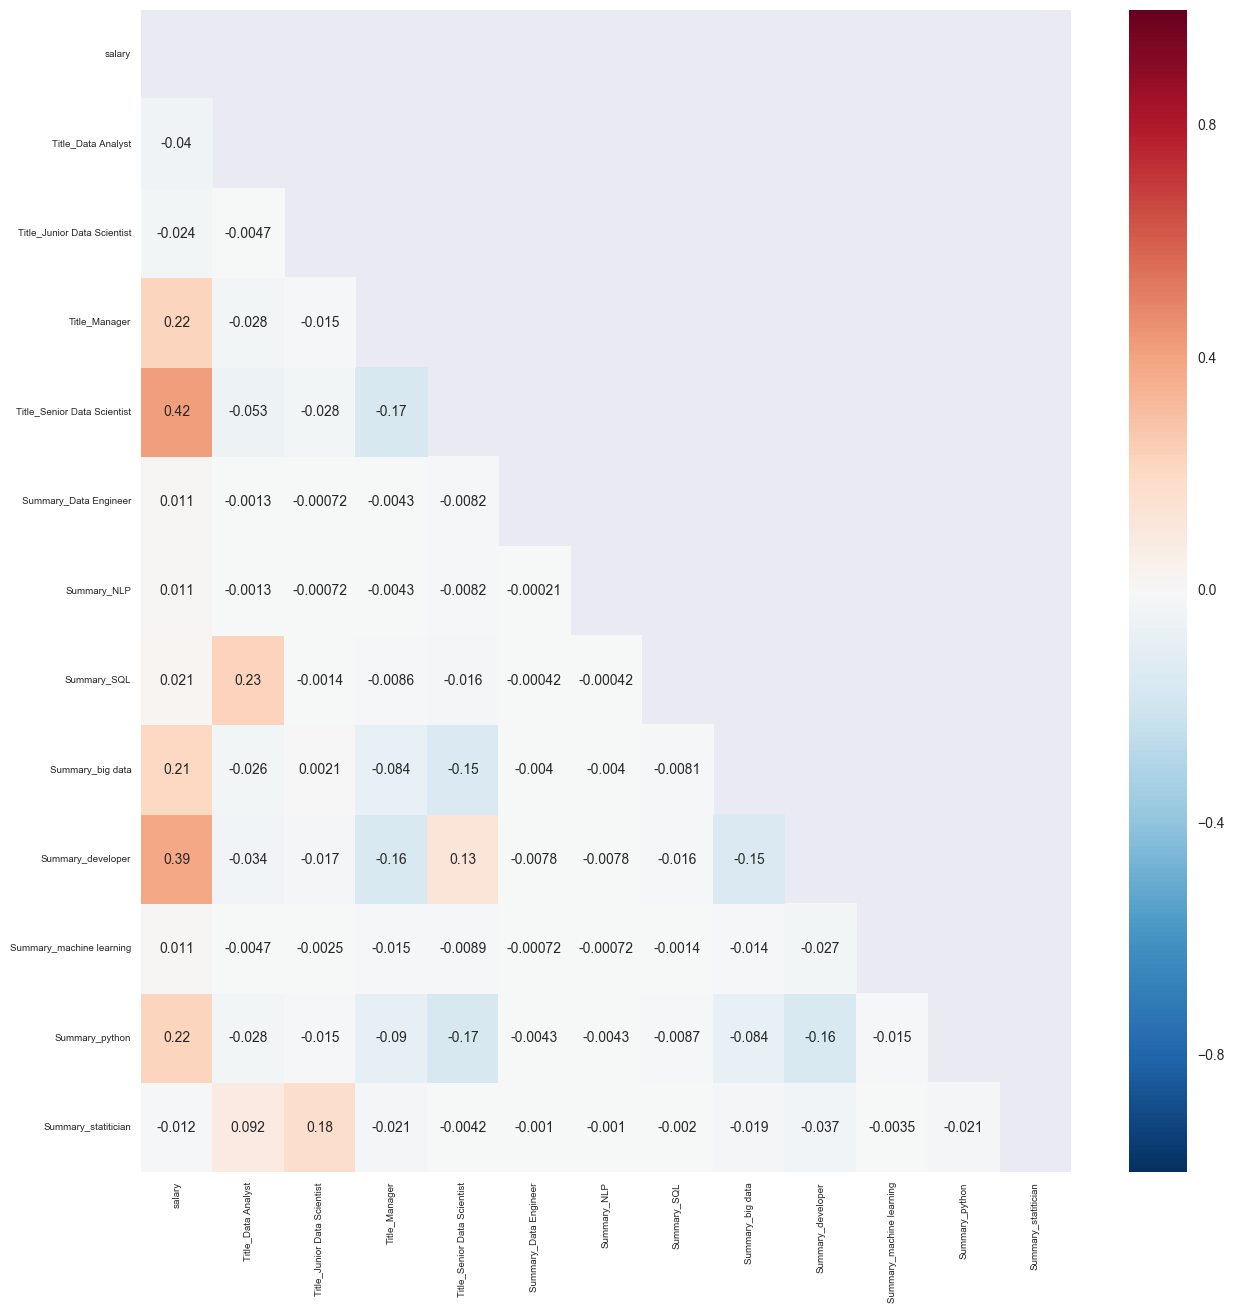

In [168]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(15,15)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(X_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(X_corr, mask=mask, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=7)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=7)

plt.show()

# Let's create a Target Variable in y

In [169]:
y = feature_df['salary']

# And, now Feature Variables in X

In [170]:
X = X.drop(['salary'], axis=1)
X.columns.values

array(['Title_Data Analyst', 'Title_Junior Data Scientist',
       'Title_Manager', 'Title_Senior Data Scientist',
       'Summary_Data Engineer', 'Summary_NLP', 'Summary_SQL',
       'Summary_big data', 'Summary_developer', 'Summary_machine learning',
       'Summary_python', 'Summary_statitician'], dtype=object)

## Predicting salaries using Logistic Regression

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm



In [ ]:
logit_model=sm.Logit(X, y)
result=logit_model.fit()
print result.summary()

In [74]:
# Perform Train_Test_Split

In [172]:
clf = linear_model.LogisticRegression(C=.01)
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [173]:
clf.score(X,y)

0.97640425976195444

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf1 = linear_model.LogisticRegression()
clf1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [175]:
probs = clf1.predict_proba(X_test)
probs[:5]

array([[ 0.01715815,  0.98284185],
       [ 0.02612233,  0.97387767],
       [ 0.02283247,  0.97716753],
       [ 0.02407238,  0.97592762],
       [ 0.02407238,  0.97592762]])

In [176]:
predicted = clf1.predict(X_test)
predicted[:5]

array([1, 1, 1, 1, 1])

In [177]:
prob=probs[:,1]
prob_df=pd.DataFrame(prob)
prob_df['predict']=np.where(prob_df[0]>=0.15,1,0)
prob_df.head()

,0,predict
0,0.982842,1
1,0.973878,1
2,0.977168,1
3,0.975928,1
4,0.975928,1


In [178]:
prob_df.predict.mean()

0.6256089074460682

In [179]:
print metrics.accuracy_score(y_true=y_test, y_pred=predicted)

0.975643702157


In [180]:
prob_df['predict']=np.where(prob_df[0]>=0.15,1,0)
prob_df.predict.mean()

0.6256089074460682

In [181]:
print metrics.accuracy_score(y_true=y_test, y_pred=predicted)

0.975643702157


In [182]:
prob=probs[:,1]
prob_df=pd.DataFrame(prob)
prob_df['predict']=np.where(prob_df[0]>=0.05,1,0)
prob_df
prob_df['actual']=y_test.values
prob_df.head()

,0,predict,actual
0,0.982842,1,1
1,0.973878,1,1
2,0.977168,1,1
3,0.975928,1,1
4,0.975928,1,1


In [183]:
confusion_matrix=pd.crosstab(prob_df['actual'],prob_df['predict'])
confusion_matrix

predict,1
actual,
0,534
1,903


In [184]:
prob=probs[:,1]
prob_df=pd.DataFrame(prob)
prob_df['predict']=np.where(prob_df[0]>=0.10,1,0)
prob_df
prob_df['actual']=y_test.values
confusion_matrix=pd.crosstab(prob_df['actual'],prob_df['predict'])
confusion_matrix

predict,0,1
actual,,
0,517,17
1,21,882


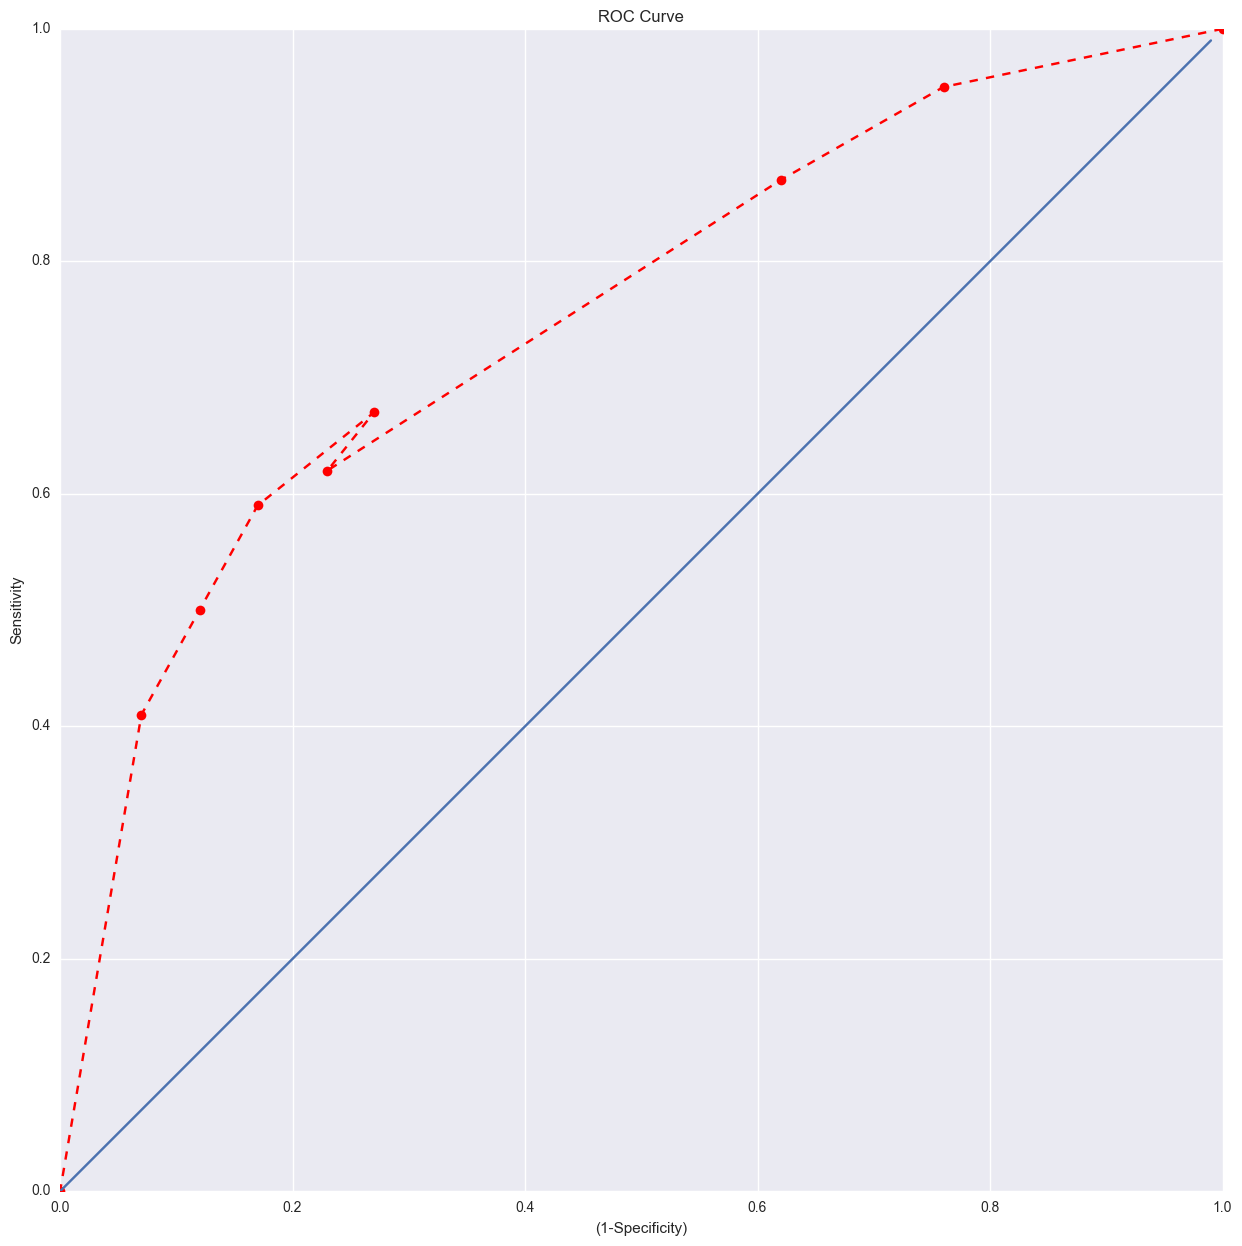

In [185]:
Sensitivity=[1,0.95,0.87,0.62,0.67,0.59,0.5,0.41,0]
FPR=[1,0.76,0.62,0.23,0.27,0.17,0.12,0.07,0]
plt.plot(FPR,Sensitivity,marker='o',linestyle='--',color='r')
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel('(1-Specificity)')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')

In [186]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("Train Score: {}".format(knn.score(X_train, y_train)))
print(" Test Score: {}".format(knn.score(X_test, y_test)))

Train Score: 0.978818615752
 Test Score: 0.976339596381


In [81]:
def standard_classification_knn(X, y, n_neighbors, random_state):
    X_train,     \
        X_test,  \
        y_train, \
        y_test = train_test_split(X, y, 
                                  random_state=random_state)

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    
    print("{} ".format(n_neighbors))
    
    return {'n_neighbors': n_neighbors,
            'train_score' : train_score,
            'test_score' : test_score}


In [82]:
standard_classification_knn(X, y, 3, random_state=42) 

3 


{'n_neighbors': 3,
 'test_score': 0.97495826377295491,
 'train_score': 0.97939292676134782}

In [83]:
results = [standard_classification_knn(X, y, n_neighbors, random_state=42) for n_neighbors in range(2,20)]

results_df = pd.DataFrame(results)
results_df.head(2)

2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 


,n_neighbors,test_score,train_score
0,2,0.974124,0.979114
1,3,0.974958,0.979393


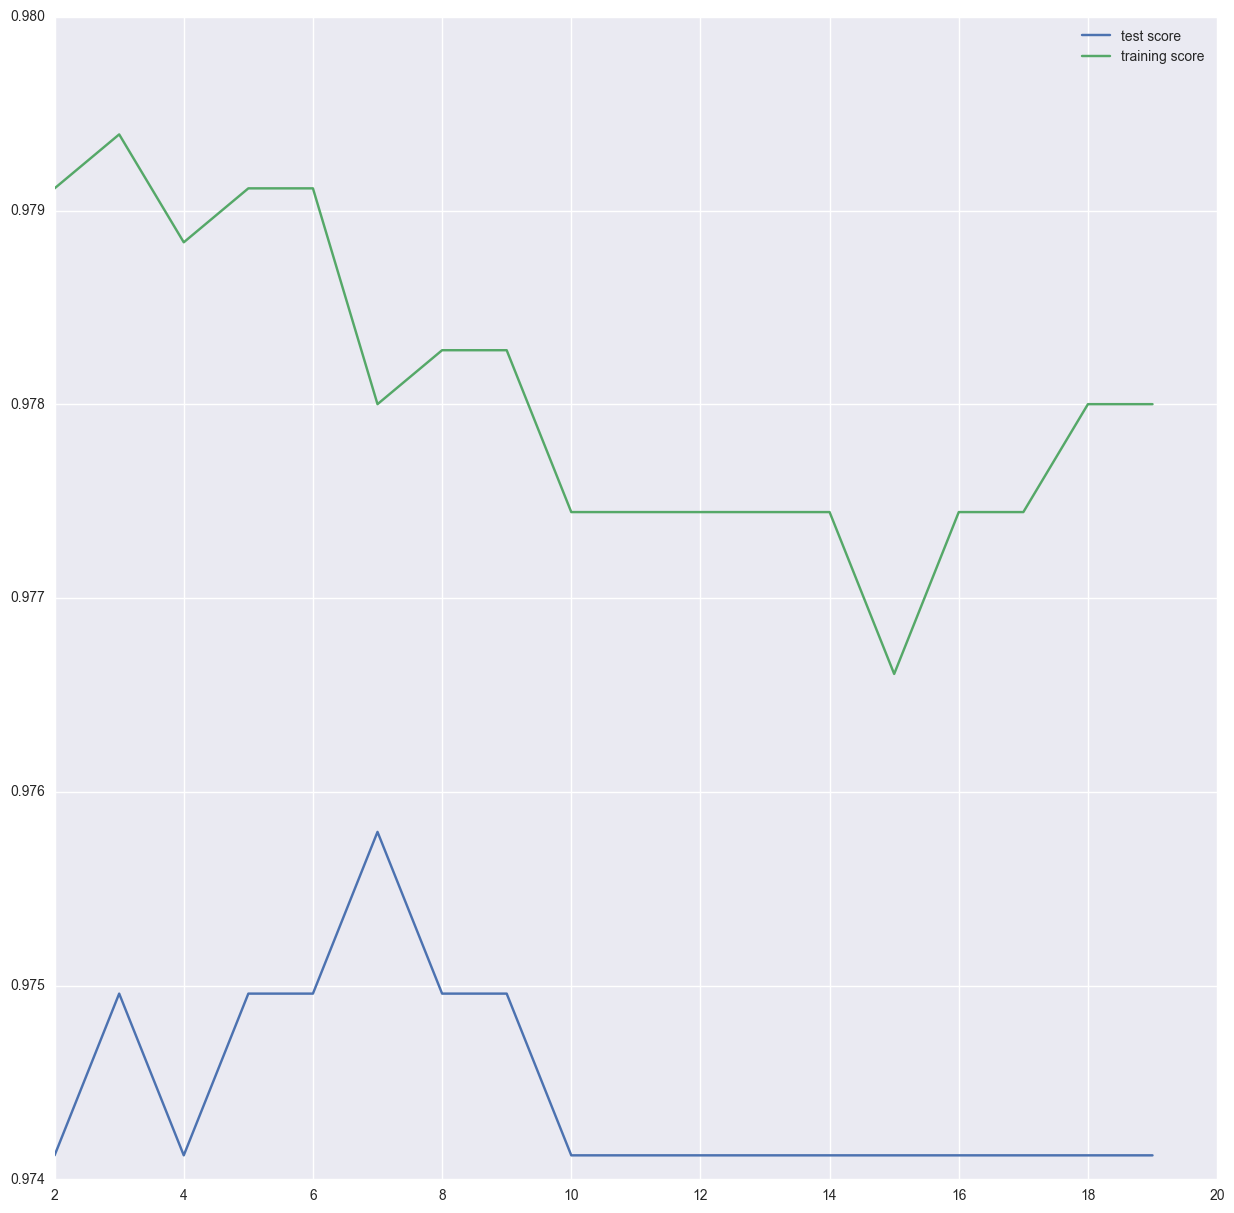

In [84]:
plt.plot(results_df['n_neighbors'], results_df['test_score'], label='test score')
plt.plot(results_df['n_neighbors'], results_df['train_score'], label='training score')
plt.legend()

2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 


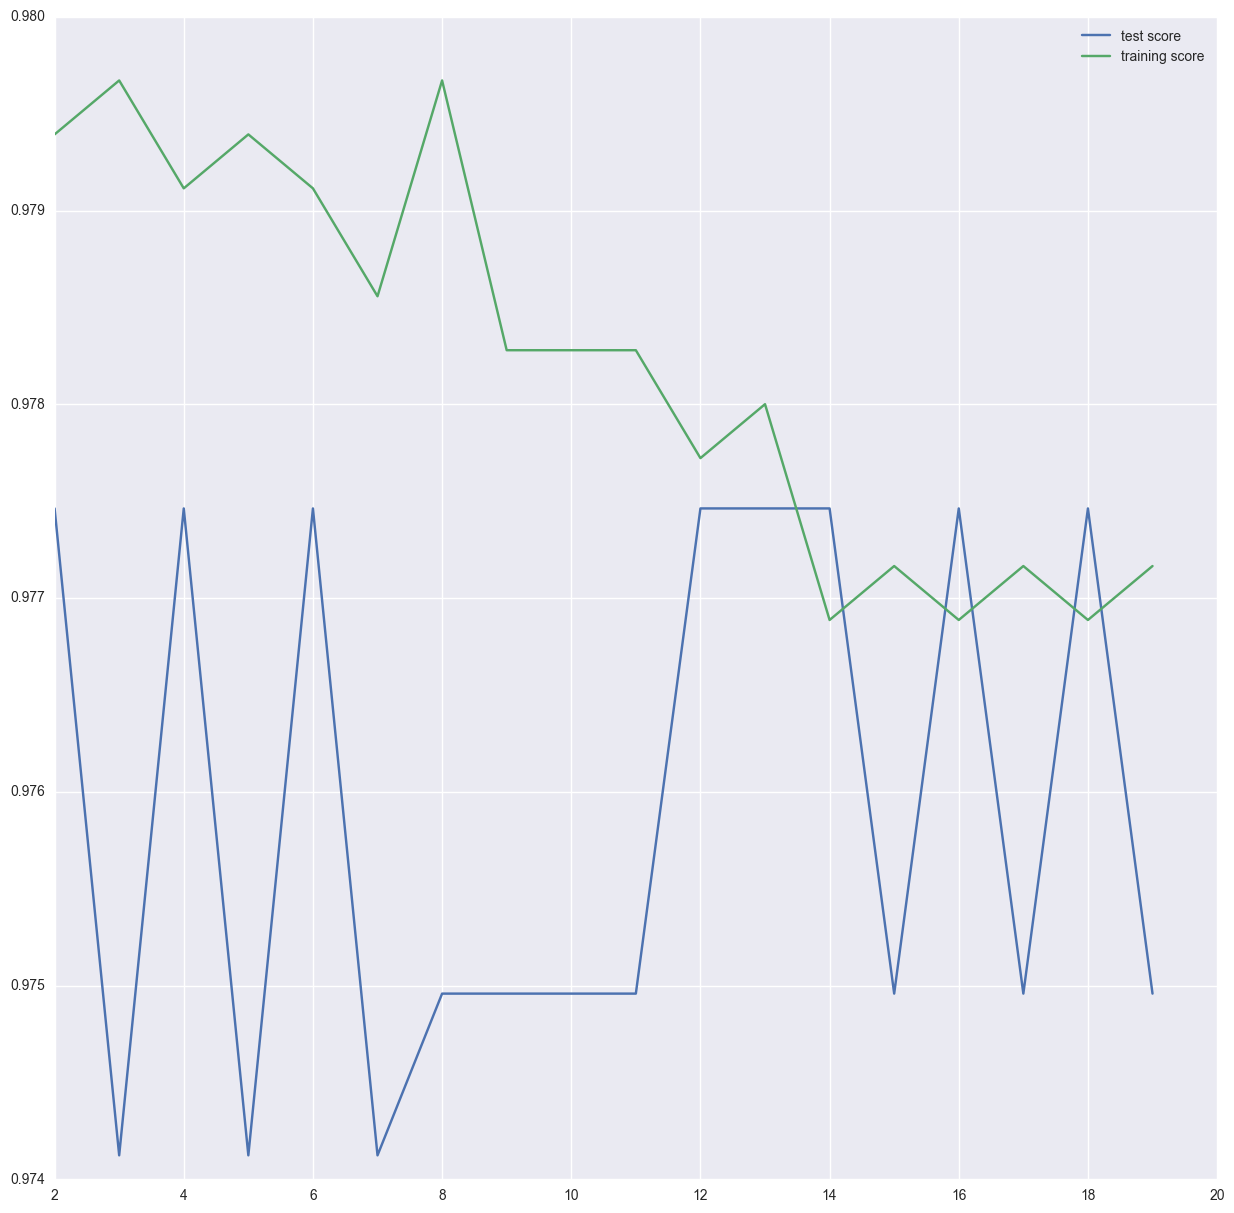

In [85]:
results = [standard_classification_knn(X, y, n_neighbors, random_state=21) for n_neighbors in range(2,20)]

results_df = pd.DataFrame(results)
plt.plot(results_df['n_neighbors'], results_df['test_score'], label='test score')
plt.plot(results_df['n_neighbors'], results_df['train_score'], label='training score')
plt.legend()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LogisticRegression()
rfe = RFE(model, 12)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1]


In [34]:
cols = X.columns.values[rfe.support_].tolist()
cols

['Title_Data Analyst',
 'Title_Junior Data Scientist',
 'Title_Manager',
 'Title_Senior Data Scientist',
 'Summary_Data Engineer',
 'Summary_NLP',
 'Summary_SQL',
 'Summary_big data',
 'Summary_developer',
 'Summary_machine learning',
 'Summary_python',
 'Summary_statitician']

In [124]:
X = X[cols]

In [35]:
params = {
    'n_neighbors':range(1,101),
    'weights':['uniform','distance']
}

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn, params, cv=5, verbose=1)
knn_gs.fit(X, y)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'n_neighbors': 1, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


In [36]:
knn = KNeighborsClassifier(n_neighbors=17, weights='distance')
scores = cross_val_score(knn, X, y, cv=10)
print scores
print np.mean(scores)

[ 0.65208333  0.60833333  0.64375     0.64583333  0.64718163  0.64644351
  0.62761506  0.64644351  0.64644351  0.65690377]
0.642103100078


In [86]:
def validate_inputs(X, y, X_test, y_test, random_state=None):
    if X_test is None and y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    elif X_test is None or y_test is None:
        raise ValueError('You need to pass both X_test and y_test.')
    else:
        X_train = X
        y_train = y

    return X_train, X_test, y_train, y_test


In [87]:
def general_regressor_standard_workflow(model, X, y,
                                        random_state=None,
                                        X_test=None,
                                        y_test=None):
    
    X_train, X_test, y_train, y_test = validate_inputs(X, y, X_test, y_test, 
                                                       random_state=random_state)
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return {
        'model' : model,
        'train_score' : train_score,
        'test_score' : test_score
    }
    

In [88]:
def general_transformer_standard_workflow(transformer, X, y, 
                                          random_state=None, 
                                          X_test=None, 
                                          y_test=None):

    X_train, X_test, y_train, y_test = validate_inputs(X, y, X_test, y_test, 
                                                       random_state=random_state)
    
    transformer.fit(X_train, y_train)
    
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)
    
    return {
        'transformer' : transformer, 
        'X_train'     : X_train,
        'X_test'      : X_test,
        'y_train'     : y_train,
        'y_test'      : y_test
    }

In [89]:
ridge_output = general_regressor_standard_workflow(Ridge(), X, y)
lasso_output = general_regressor_standard_workflow(Lasso(), X, y)
ols_output = general_regressor_standard_workflow(LinearRegression(), X, y)
sgd_output = general_regressor_standard_workflow(SGDRegressor(), X, y)
elasticnet_output = general_regressor_standard_workflow(ElasticNet(), X, y, random_state=42)

In [90]:
print "Ridge:       ", ridge_output['train_score'], ridge_output['test_score']
print "Lasso:       ", lasso_output['train_score'], lasso_output['test_score']
print "Elastic Net: ", elasticnet_output['train_score'], elasticnet_output['test_score']
print "OLS:         ", ols_output['train_score'], ols_output['test_score']
print "SGD:         ", sgd_output['train_score'], sgd_output['test_score']


Ridge:        0.771080212878 0.776362671382
Lasso:        0.0 -5.65256863743e-05
Elastic Net:  0.0 -0.000329666449384
OLS:          0.77130591245 0.772965745071
SGD:          0.678957648734 0.702722714243


In [91]:
def load_data_and_split():
    #target = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
    return X_train, X_test, y_train, y_test

load_data_and_split()

X_train, X_test, y_train, y_test = load_data_and_split()

ridge_regressor = Lasso()

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridge_regressor.fit(X_train, y_train)

def score_me(scorer, model, X, y):
    return scorer(model.predict(X), y)

print("MAE train {}".format(score_me(mean_absolute_error, ridge_regressor, X_train, y_train)))
print("MAE test  {}".format(score_me(mean_absolute_error, ridge_regressor, X_test,  y_test)))
print("MSE train {}".format(score_me(mean_squared_error, ridge_regressor, X_train, y_train)))
print("MSE test  {}".format(score_me(mean_squared_error, ridge_regressor, X_test,  y_test)))
print("R2  train {}".format(score_me(r2_score, ridge_regressor, X_train, y_train)))
print("R2  test  {}".format(score_me(r2_score, ridge_regressor, X_test,  y_test)))

MAE train 0.458624825624
MAE test  0.455817944044
MSE train 0.229312412812
MSE test  0.226505531232
R2  train -4.65100828386e+30
R2  test  -1.83763118477e+31


#### Thought experiment: What is the baseline accuracy for this model?


#### Calculate the baseline accuracy

baseline_accuracy = majority_class_N / total_population


In [125]:
baseline_accuracy = 1. - np.mean(df.salary)
print "Baseline Accuracy = ", baseline_accuracy

Baseline Accuracy =  0.512315270936


## Metric:
 Our metric for the logistic regression is going to be the AUC (Area Under the Curve), which was well over the baseline accuracy, so our ROC curve was a success.

## Benchmark/Conclusion:
 At about 97% our features were excellent predicters of estimated salary.